# **PREPROCESSING**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder

from typing import Dict, List, Union

In [2]:
label_mapping = {
    # DDoS
    'DDoS-ACK_Fragmentation': 'DDoS',
    'DDoS-UDP_Flood': 'DDoS',
    'DDoS-SlowLoris': 'DDoS',
    'DDoS-ICMP_Flood': 'DDoS',
    'DDoS-RSTFINFlood': 'DDoS',
    'DDoS-PSHACK_Flood': 'DDoS',
    'DDoS-HTTP_Flood': 'DDoS',
    'DDoS-UDP_Fragmentation': 'DDoS',
    'DDoS-TCP_Flood': 'DDoS',
    'DDoS-SYN_Flood': 'DDoS',
    'DDoS-SynonymousIP_Flood': 'DDoS',
    'DDoS-ICMP_Fragmentation': 'DDoS',
    
    # DoS
    'DoS-TCP_Flood': 'DoS',
    'DoS-HTTP_Flood': 'DoS',
    'DoS-SYN_Flood': 'DoS',
    'DoS-UDP_Flood': 'DoS',
    
    # Brute Force
    'DictionaryBruteForce': 'Brute Force',
    
    # Spoofing
    'MITM-ArpSpoofing': 'Spoofing',
    'DNS_Spoofing': 'Spoofing',
    
    # Recon
    'Recon-PingSweep': 'Recon',
    'Recon-OSScan': 'Recon',
    'VulnerabilityScan': 'Recon',
    'Recon-PortScan': 'Recon',
    'Recon-HostDiscovery': 'Recon',
    
    # Web-based
    'SqlInjection': 'Web-based',
    'CommandInjection': 'Web-based',
    'Backdoor_Malware': 'Web-based',
    'Uploading_Attack': 'Web-based',
    'XSS': 'Web-based',
    'BrowserHijacking': 'Web-based',
    
    # Mirai
    'Mirai-greip_flood': 'Mirai',
    'Mirai-greeth_flood': 'Mirai',
    'Mirai-udpplain': 'Mirai',
    
    # Benign Traffic
    'BenignTraffic': 'Benign'
}

def GroupAttacks(label):
    return label_mapping.get(label, 'Unknown') # Default to 'unknown'

In [3]:
def essential_preprocessing(df: pd.DataFrame) -> pd.DataFrame:
    """Essential preprocessing for partitioning the data"""
    
    # Label columns
    #     attack_cat      8 categories: Bening, DDoS, DoS, Recon, Mirai, Web-based, Spoofing, Brute Force
    #     attack_type     34 categories: Benign and 33 attacks
    df = df.drop(columns=['grouped_label'])
    df['attack_cat'] = df['label'].map(GroupAttacks)
    df['attack_type'] = df['label']
    df.replace({'attack_cat': {'BenignTraffic': 'Benign'}, 'attack_type': {'BenignTraffic': 'Benign'}}, inplace=True)

    # Convert categorical labels to numerical labels
    label_encoder = LabelEncoder()
    df["attack_cat"] = label_encoder.fit_transform(df["attack_cat"])
    
    unique_attacks = ['Benign'] + sorted(set(df["attack_type"]) - {"Benign"})
    attack_type_mapping = {attack: idx for idx, attack in enumerate(unique_attacks)}
    df["attack_type"] = df["attack_type"].map(attack_type_mapping)

    return df

def reverse_preprocessing(df: pd.DataFrame) -> pd.DataFrame:
    """Reverses the preprocessing steps"""

    return df.drop(columns=['attack_cat', 'attack_type']) # Remove additional labels

In [4]:
def LabelEncoding(df_initial: pd.DataFrame) -> pd.DataFrame:
    """Generate an additional DataFrame with the numerical codification of the labels"""
    
    # Extract attack categories and types (names)
    names = df_initial[['grouped_label', 'label']].value_counts().reset_index()
    names.columns = ['grouped_label', 'label', 'count']
    names['label'] = names['label'].replace('BenignTraffic', 'Benign')
    attack_cat_names = ['Benign'] + sorted(set(names['grouped_label']) - {'Benign'})
    attack_type_names = ['Benign'] + sorted(set(names['label']) - {'Benign'})

    # Extract numerical codification for attack categories and types
    attack_cat_mapping = {name: idx for idx, name in enumerate(attack_cat_names)}
    attack_type_mapping = {name: idx for idx, name in enumerate(attack_type_names)}

    names['attack_cat_num'] = names['grouped_label'].map(attack_cat_mapping)
    names['attack_type_num'] = names['label'].map(attack_type_mapping)

    df_labels = names[['grouped_label', 'attack_cat_num', 'label', 'attack_type_num', 'count']].drop_duplicates()
    df_labels = df_labels.rename(columns={'grouped_label': 'attack_cat_name', 'label': 'attack_type_name'})

    mask = df_labels['attack_cat_name'] == 'Web-based'
    df_labels.loc[mask, 'attack_type_name'] = 'WebBased-' + df_labels.loc[mask, 'attack_type_name']

    df_labels.loc[df_labels['attack_type_name'] == 'VulnerabilityScan', 'attack_type_name'] = 'Recon-' + df_labels.loc[df_labels['attack_type_name'] == 'VulnerabilityScan', 'attack_type_name']

    mask = df_labels['attack_cat_name'] == 'Spoofing'
    df_labels.loc[mask, 'attack_type_name'] = ('Spoofing-' + df_labels.loc[mask, 'attack_type_name'].str.replace('Spoofing[_-]?', '', regex=True).str.replace('_', '', regex=False))

    return df_labels

In [5]:
def FullAttackTypeDistribution(df_labels: pd.DataFrame) -> None:
    """Visualize the distribution (number of samples) of each attack type"""
    
    df_attacks = df_labels[df_labels['attack_cat_name'] != 'Benign']
    df_attacks = df_attacks.sort_values(by=['count', 'attack_type_name'], ascending=[False, True])

    categories = ['DDoS', 'Recon', 'Spoofing', 'Mirai', 'DoS', 'Brute Force', 'Web-based']
    palette = sns.color_palette("twilight_shifted", len(categories))
    color_map = dict(zip(categories, palette))
    colors_attack = [color_map[g] for g in df_attacks["attack_cat_name"]]
    
    
    plt.figure(figsize=(15, 10))

    plt.barh(df_attacks['attack_type_name'],df_attacks['count'], color=colors_attack)
    plt.xlabel('Count')
    plt.ylabel('Attack Type')
    plt.title('Attack Category Distribution', fontsize=16, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    
    handles = [plt.Rectangle((0, 0), 1, 1, color=color_map[g]) for g in categories]
    plt.legend(handles, categories, title="Attack Category", loc="lower right")
    plt.show()

In [6]:
def FullAttackCategoryDistribution(df_labels: pd.DataFrame, lim:int) -> None:
    """Visualize the distribution (number of samples) of each attack category"""

    df_attacks = df_labels[df_labels['attack_cat_name'] != 'Benign']
    df_cat = df_attacks.groupby('attack_cat_name')['count'].sum().reset_index().sort_values('count', ascending=False)
    df_cat['percentage'] = (df_cat['count'] / df_cat['count'].sum()) * 100
    
    plt.figure(figsize=(12, 8))
    bars = plt.barh(df_cat['attack_cat_name'],df_cat['count'], color='grey')
    min_bar_width = min(bar.get_width() for bar in bars)
    ax = plt.gca()

    for bar, count, percentage in zip(bars, df_cat['count'], df_cat['percentage']):
        yval = bar.get_width() 
        if yval < lim:
            ax.text(yval + 0.3*min_bar_width, bar.get_y() + bar.get_height() / 2, f'{count} ({percentage:.2f}%)', ha='left', va='center', color='black', fontsize=12, fontweight='bold')
        else:
            ax.text(yval - 0.4*min_bar_width, bar.get_y() + bar.get_height() / 2, f'{count} ({percentage:.2f}%)', ha='right', va='center', color='black', fontsize=12, fontweight='bold')
                
    plt.xlabel('Count')
    plt.ylabel('Attack Category')
    plt.title('Attack Category Distribution')
    plt.gca().invert_yaxis()
    plt.grid(axis='x', linestyle='--', alpha=0.7)

In [7]:
df_initial = pd.read_csv("..\\datasets\\EquitativeDataset.csv").dropna()

In [8]:
df = essential_preprocessing(df_initial)

Generate a DataFrame containing all the numerical codifications of each label

In [9]:
df_labels = LabelEncoding(df_initial)
df_labels.to_csv("..\\datasets\\df_labels.csv", index=False)
df_labels

,attack_cat_name,attack_cat_num,attack_type_name,attack_type_num,count
0,Benign,0,Benign,0,1098195
1,DoS,3,DoS-HTTP_Flood,18,37000
2,Spoofing,6,Spoofing-MITM-Arp,22,37000
3,Spoofing,6,Spoofing-DNS,16,37000
4,Recon,5,Recon-VulnerabilityScan,32,37000
5,Recon,5,Recon-PortScan,29,37000
6,Recon,5,Recon-OSScan,27,37000
7,Recon,5,Recon-HostDiscovery,26,37000
8,Mirai,4,Mirai-udpplain,25,37000
9,Mirai,4,Mirai-greip_flood,24,37000


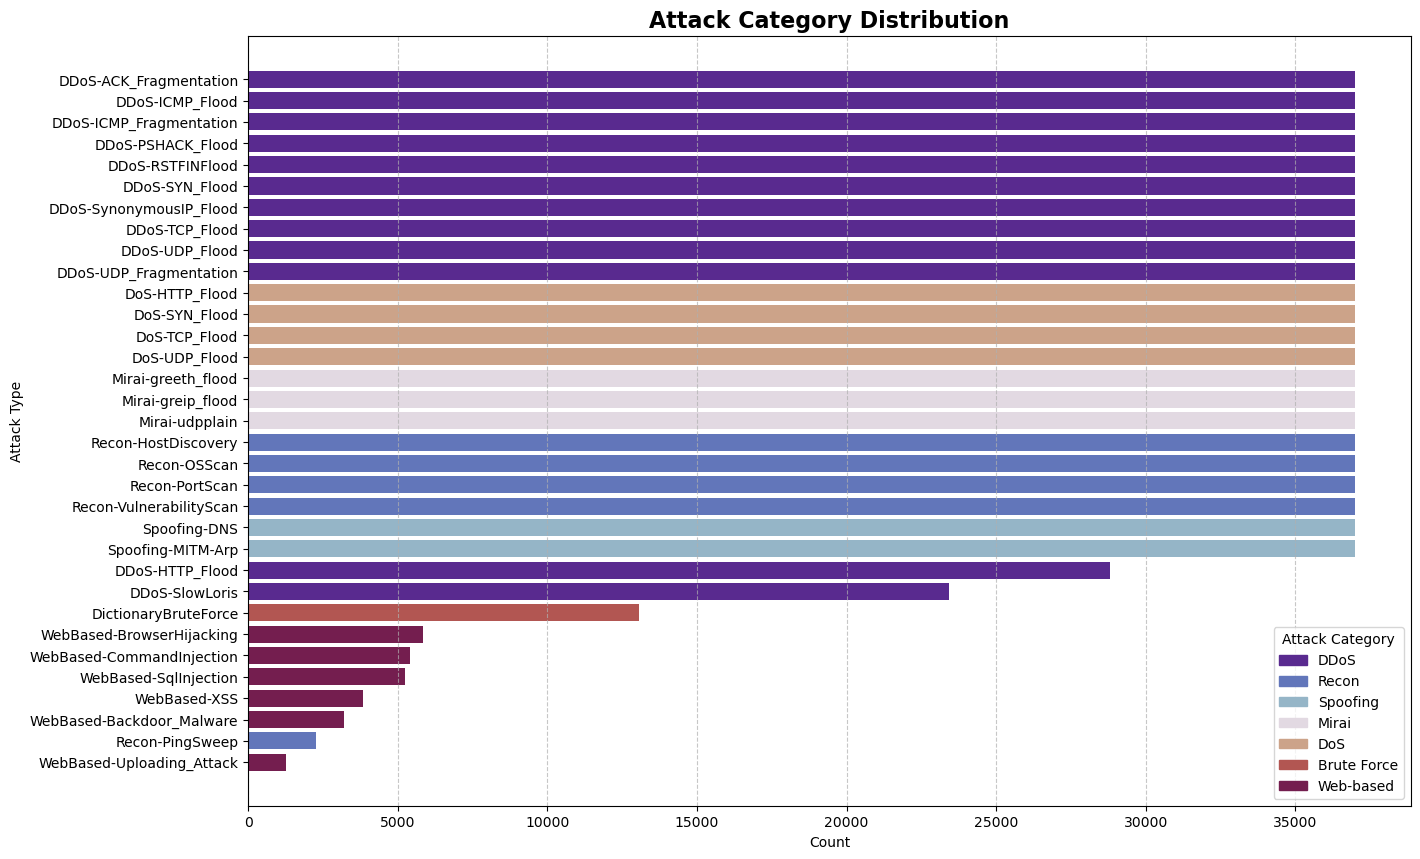

In [10]:
FullAttackTypeDistribution(df_labels)

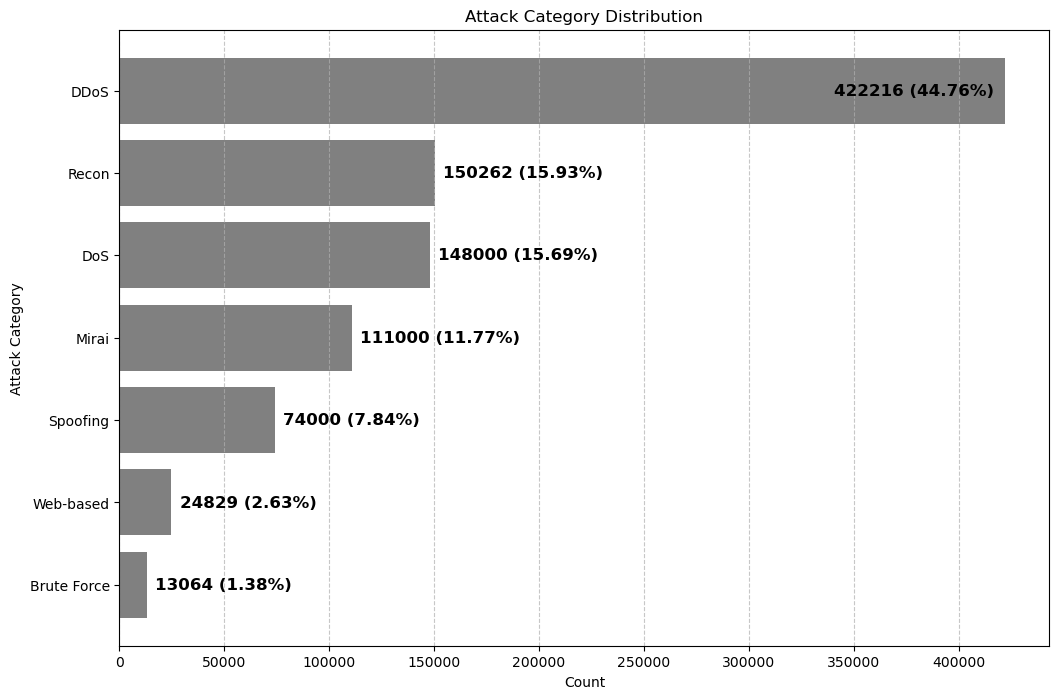

In [11]:
FullAttackCategoryDistribution(df_labels, 200000)

# **DATA PARTITIONS**

In [12]:
def AttackTypeDistribution(partitions: Union[pd.DataFrame, Dict[str, List[pd.DataFrame]]], nodes: int, df_labels: pd.DataFrame, part: str = "balanced") -> None:
    """For each node in the environment, plot showing the amount of samples per attack type"""

    global_counts = df_labels[['attack_type_name', 'count']].drop_duplicates()
    
    for i in range(nodes):
        df_part = partitions[f"part_{i}"] if nodes > 1 else partitions
    
        df_merged = df_part.merge(df_labels[['attack_type_num', 'attack_type_name', 'attack_cat_name']],
                                  left_on='attack_type', right_on='attack_type_num', how='left')
    
        # Filter out Benign attack categories for visualization and assign colors to each attack category
        df_attacks = df_merged[df_merged['attack_cat_name'] != 'Benign']
        
        categories = ['DDoS', 'Recon', 'Spoofing', 'Mirai', 'DoS', 'Brute Force', 'Web-based']
        palette = sns.color_palette("twilight_shifted", len(categories))
        color_map = dict(zip(categories, palette))
        colors_attack = [color_map[g] for g in df_attacks["attack_cat_name"]]
        
        # Count the occurrences of each 'attack_type' in the partition
        attack_counts = df_attacks[['attack_cat_name', 'attack_type_name']].value_counts().reset_index(name='count')
        attack_counts = attack_counts.merge(global_counts, on='attack_type_name', how='left', suffixes=('', '_global'))
        attack_counts = attack_counts.sort_values(by=['count_global', 'attack_type_name'], ascending=[False, True])
        
        # Create a bar plot
        plt.figure(figsize=(12, 8))
        plt.barh(attack_counts['attack_type_name'], attack_counts['count'], color=[color_map[cat] for cat in attack_counts['attack_cat_name']])
        if nodes > 1 :
           plt.title(f"Attacks Distribution in Node {i+1}", fontsize=16, fontweight='bold')
        else: 
            plt.title("Attacks distribution in the Test Dataset", fontsize=16, fontweight='bold')
        plt.ylabel("Attack Type")
        plt.xlabel("Count")
        if part == "unbalanced":
            plt.xlim(0, 15200)
        
        plt.gca().invert_yaxis()  # Highest count on top
        plt.grid(axis='x', linestyle='--', alpha=0.7)

        if not (part == "unbalanced" and (i == 0 or i ==1)):
            handles = [plt.Rectangle((0, 0), 1, 1, color=color_map[g]) for g in categories]
            plt.legend(handles, categories, title="Attack Category", loc="lower right")
        
        plt.tight_layout()
        plt.show()

In [13]:
def AttackCategoryDistribution(partitions: Union[pd.DataFrame, Dict[str, List[pd.DataFrame]]], nodes: int, df_labels: pd.DataFrame, lim:int = 130000, part:str =None) -> None:
    """For each node in the environment, plot showing the amount of samples per attack category and benign traffic"""
    
    if nodes == 1:
        fig, axes = plt.subplots(1, nodes, figsize=(12, 8))
        axes = [axes]
    else:
        fig, axes = plt.subplots(1, nodes, figsize=(18, 6))

    if part:
        fig.suptitle(part, fontsize=16, fontweight='black')
    for i in range(nodes):
        df_part = partitions[f"part_{i}"] if nodes > 1 else partitions
        
        attack_counts = df_part['attack_cat'].value_counts().reset_index(name='count')
        attack_counts = attack_counts.merge(df_labels[['attack_cat_num', 'attack_cat_name']], left_on='attack_cat', right_on='attack_cat_num', how='left')
        attack_counts = attack_counts.drop_duplicates(subset=['attack_cat_name'])
        
        attack_counts['percentage'] = (attack_counts['count'] / attack_counts['count'].sum()) * 100
        ax = axes[i]
        bars = ax.barh(attack_counts['attack_cat_name'], attack_counts['count'], color='grey')
        min_bar_width = min(bar.get_width() for bar in bars)

        for bar, count, percentage in zip(bars, attack_counts['count'], attack_counts['percentage']):
            yval = bar.get_width() 
            if yval < lim:
                ax.text(yval + 0.3*min_bar_width, bar.get_y() + bar.get_height() / 2, f'{count} ({percentage:.2f}%)', ha='left', va='center', color='black', fontsize=12, fontweight='bold')
            else:
                ax.text(yval - 0.4*min_bar_width, bar.get_y() + bar.get_height() / 2, f'{count} ({percentage:.2f}%)', ha='right', va='center', color='black', fontsize=12, fontweight='bold')
         
        if nodes > 1:
            ax.set_title(f"Attack's category Distribution in Node {i+1}")
        else:
            ax.set_title("Attack's category Distribution in the Test Dataset")
        ax.set_ylabel("Traffic Category")
        ax.set_xlabel("Count")
        ax.invert_yaxis()
        ax.grid(axis='x', linestyle='--', alpha=0.7)
        
    plt.tight_layout()
    plt.show()

In [14]:
def TrafficDistribution(partitions: Union[pd.DataFrame, Dict[str, List[pd.DataFrame]]], nodes:int , part:str = None) -> None:
    """For each node in the environment, plot showing the amount of attack and bening traffic samples"""
    
    if nodes == 1:
        fig, axes = plt.subplots(1, nodes, figsize=(8, 6))
        axes = [axes]
    else:
        fig, axes = plt.subplots(1, nodes, figsize=(18, 6))

    if part:
        fig.suptitle(part, fontsize=16, fontweight='black')
    for i in range(nodes):
        df_part = partitions[f"part_{i}"] if nodes > 1 else partitions
        
        attack_counts = df_part['attack_cat'].value_counts().reset_index(name='count')
        attack_counts['attack_cat_grouped'] = attack_counts['attack_cat'].apply(lambda x: 'Benign' if x == 0 else 'Attack')
        attack_counts = attack_counts.groupby('attack_cat_grouped', as_index=False)['count'].sum()
        attack_counts.rename(columns={'attack_cat_grouped': 'attack_category'}, inplace=True)
        
        attack_counts['percentage'] = (attack_counts['count'] / attack_counts['count'].sum()) * 100
        
        ax = axes[i]
        bars = ax.bar(attack_counts['attack_category'], attack_counts['count'], color='black')
        for bar, percentage in zip(bars, attack_counts['percentage']):
            yval = bar.get_height() 
            ax.text(bar.get_x() + bar.get_width() / 2, yval / 2, f'{percentage:.2f}%', ha='center', va='center', color='white', fontsize=18, fontweight='bold')

        if nodes > 1:
            ax.set_title(f"Attack Distribution in Node {i+1}")
        else:
            ax.set_title("Attack Distribution in the Test Dataset")
        ax.set_xlabel("Traffic Type")
        ax.set_ylabel("Count")

    plt.tight_layout()
    plt.show()

## **SPLIT TEST DATA**

In [15]:
def StratifiedSampling(df: pd.DataFrame, label_col: str, fraction: float, random_state: int = 42) -> pd.DataFrame:
    df_grouped = df.groupby(label_col)
    return df_grouped.sample(frac=fraction, random_state=random_state)

In [16]:
# Split into Train + Validation (90%) and Test (10%)
df_test = StratifiedSampling(df, label_col='attack_type', fraction=0.1) # Select 10% of each attack type 
df_train_val = df.drop(df_test.index)

print(f"The Test Dataset contains {len(df_test)} samples ({(len(df_test)/len(df))*100:.2f}% of the dataset).")

reverse_preprocessing(df_test).to_csv(f"..\\datasets\\df_test.csv", index=False) # Save it 

The Test Dataset contains 204157 samples (10.00% of the dataset).


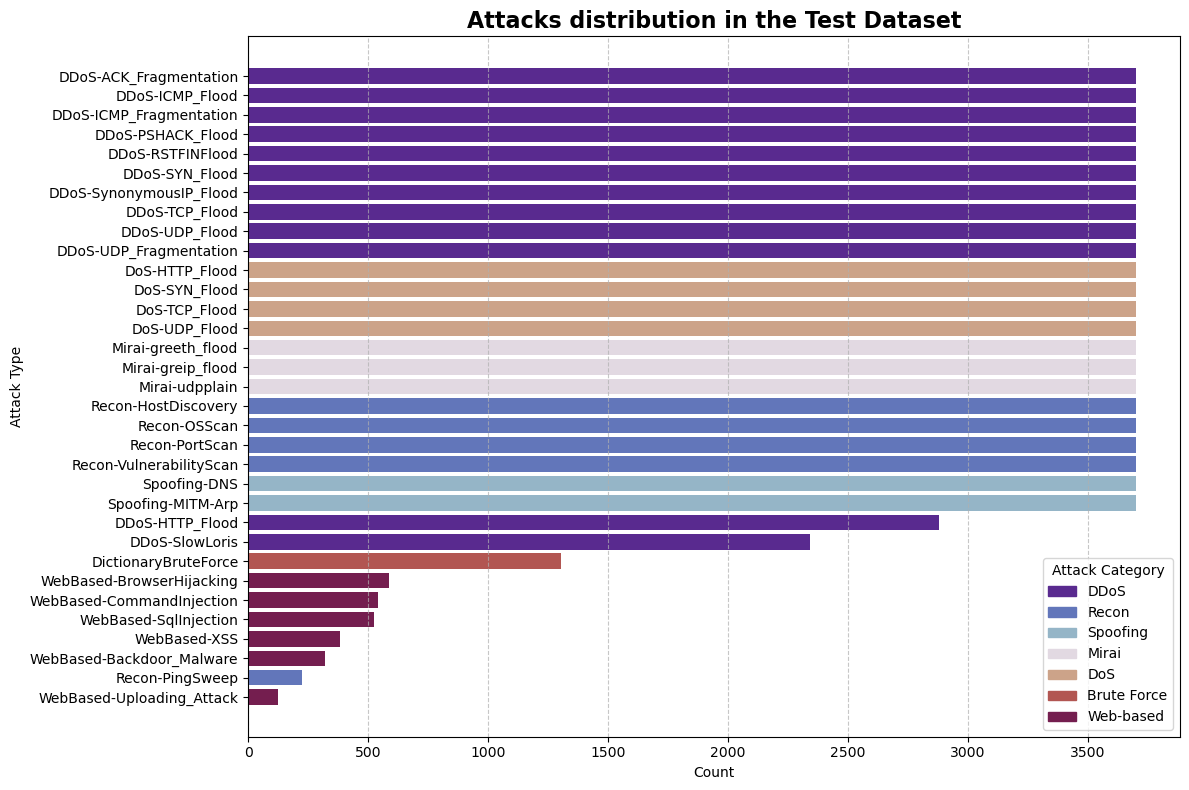

In [17]:
AttackTypeDistribution(df_test, 1, df_labels)

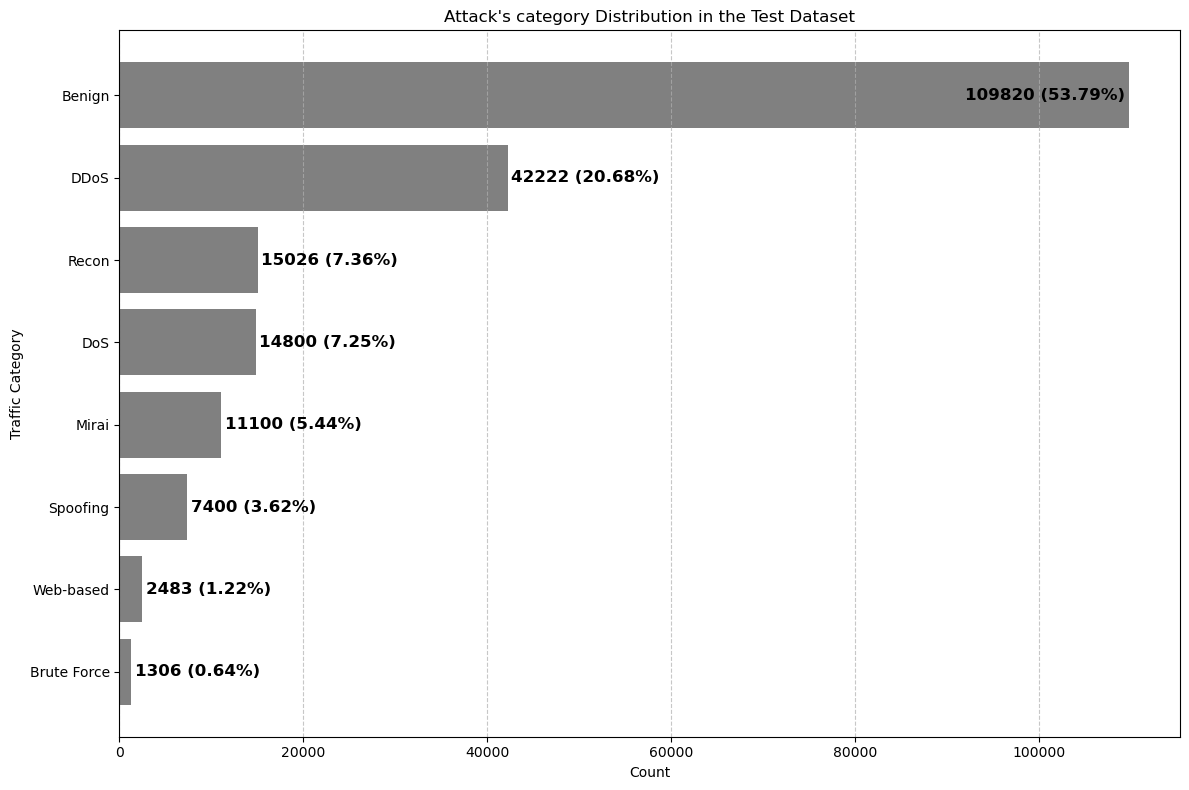

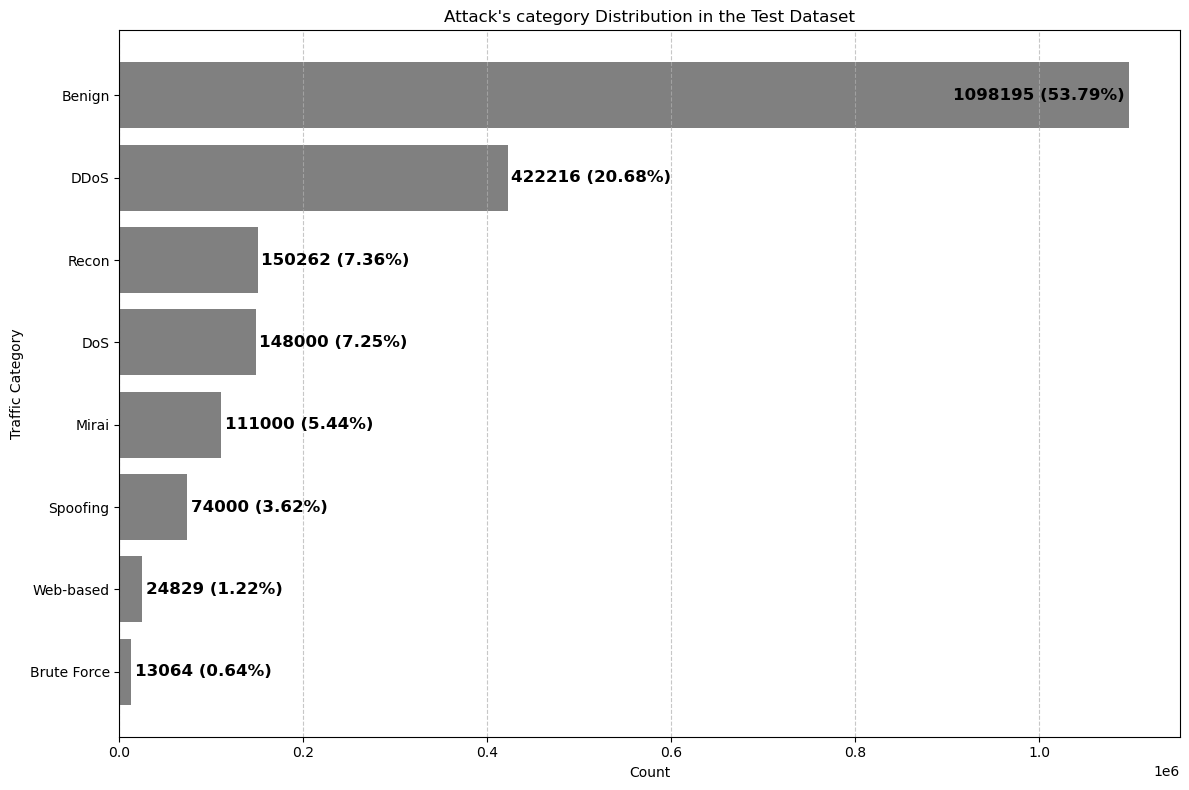

In [18]:
AttackCategoryDistribution(df_test, 1, df_labels, lim=4.3e4)
AttackCategoryDistribution(df, 1, df_labels, 4.3e5)

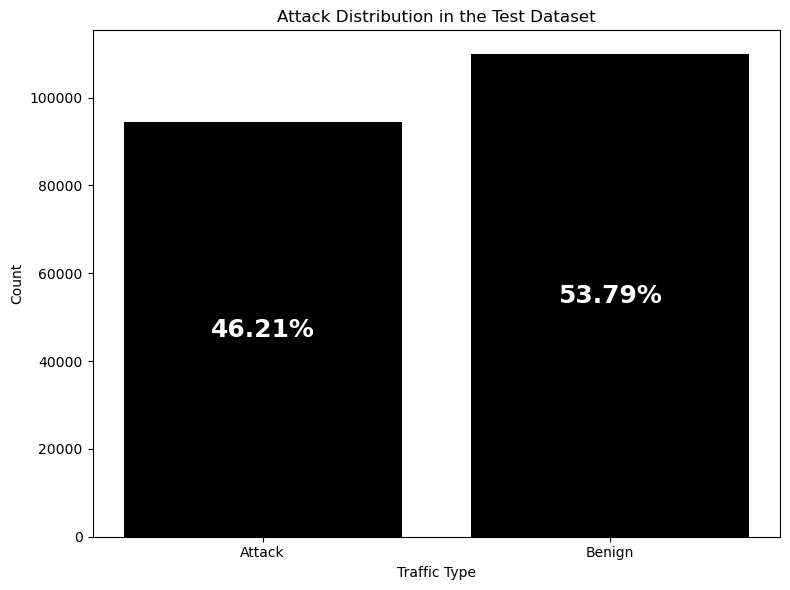

In [19]:
TrafficDistribution(df_test, 1)

## **UNIFORM PARTITIONS**

In [20]:
def AttackEquitativePartitions(df: pd.DataFrame, categories: List, nodes: int, random_state: int = 42) -> Dict[str, List[pd.DataFrame]]:
    """Divides the DataFrame 'df' into a specified number of nodes ensuring the same amount of samples of 'categories' in each one"""

    np.random.seed(random_state) # For reproducibility
    partitions = {f"part_{i}": [] for i in range(nodes)} # Dictionary to store partitions

    # Distribute attack samples
    for idx, attack_category in enumerate(categories):
        df_cat = df[df['attack_cat'] == attack_category] # Filter by attack category
        
        for attack in df_cat['attack_type'].unique():
            df_attack = df_cat[df_cat['attack_type'] == attack] # Filter by attack type
            num_samples = len(df_attack)
            samples_per_node = num_samples // nodes

            for i in range(nodes):
                start_idx = i * samples_per_node
                end_idx = (start_idx + samples_per_node) if i < (nodes - 1) else num_samples  # Last node gets remaining data
                partitions[f"part_{i}"].append(df_attack.iloc[start_idx:end_idx])

    
    # Distribute Benign samples 
    df_benign = df[df['attack_cat'] == 0]
    num_benign = len(df_benign)
    benign_per_node = num_benign // nodes
    
    for i in range(nodes):
        start_idx = i * benign_per_node
        end_idx = start_idx + benign_per_node if i < nodes - 1 else num_benign  # Last node gets remaining data
        partitions[f"part_{i}"].append(df_benign.iloc[start_idx:end_idx])

    
    # Concatenate all parts per node
    for i in range(nodes):
        partitions[f"part_{i}"] = pd.concat(partitions[f"part_{i}"], ignore_index=True)

    return partitions

In [21]:
nodes = 3
partitions_eq3 = AttackEquitativePartitions(df_train_val, df_train_val[df_train_val['attack_cat'] != 0]['attack_cat'].unique(), nodes)

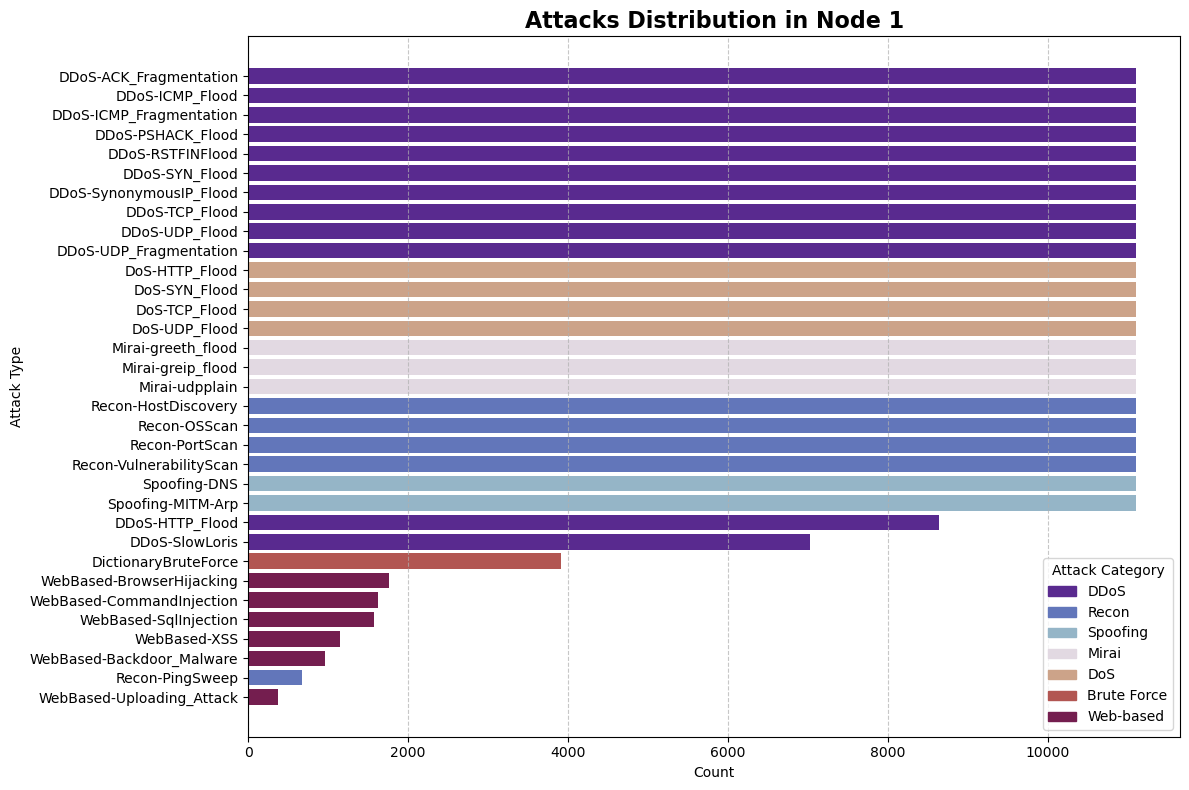

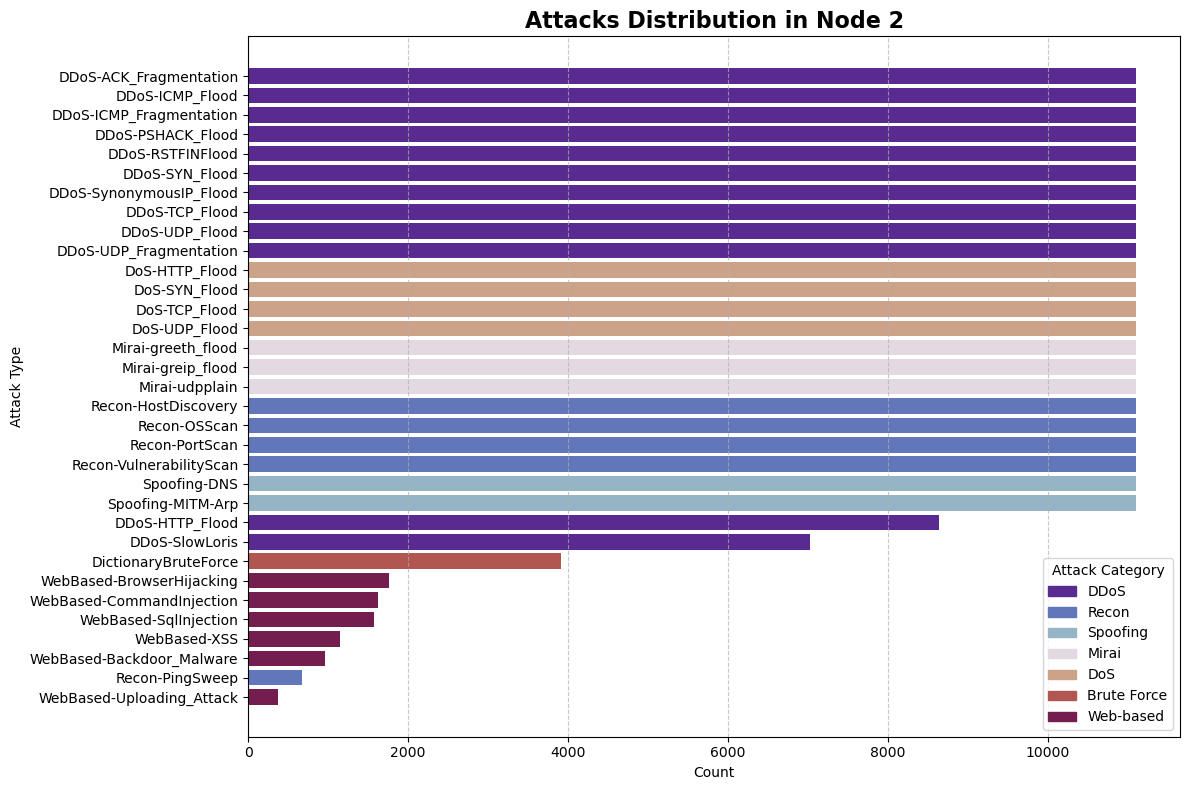

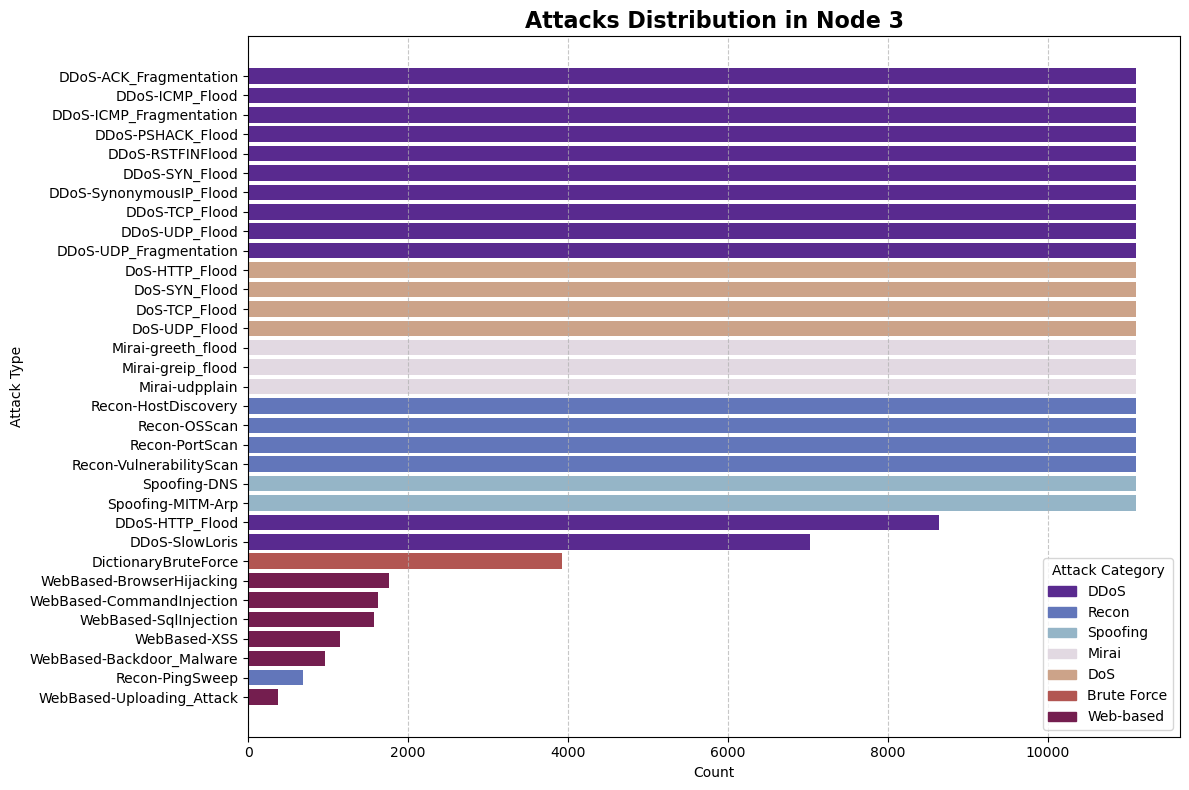

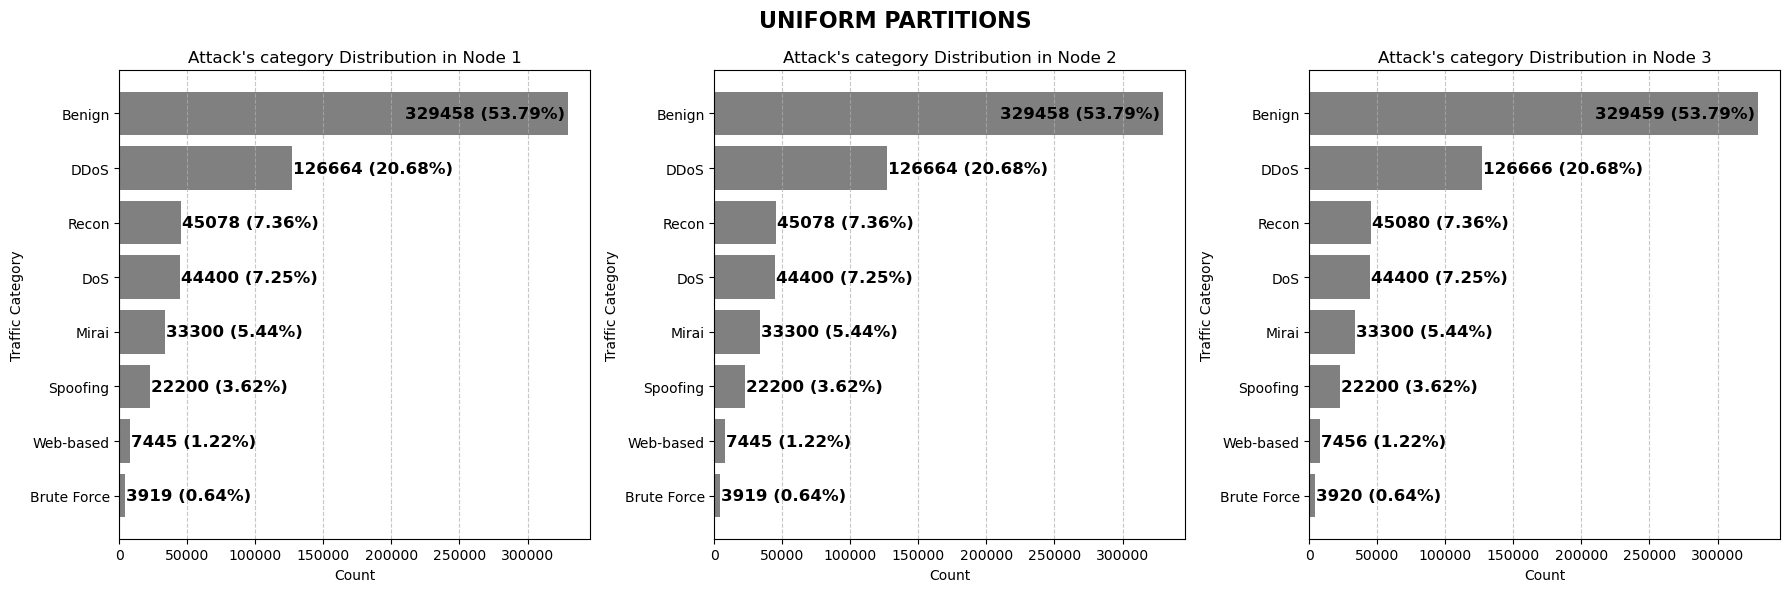

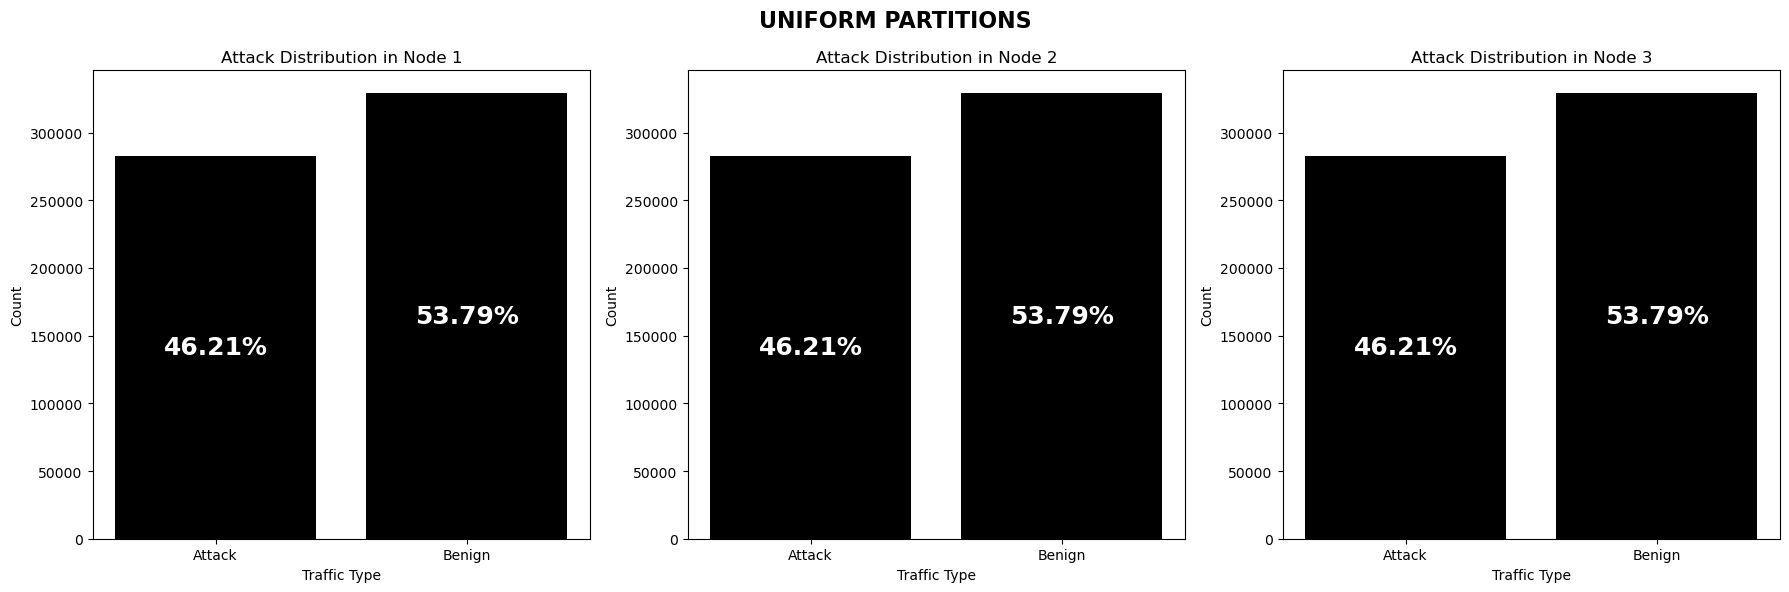

In [22]:
AttackTypeDistribution(partitions_eq3, nodes, df_labels)
AttackCategoryDistribution(partitions_eq3, nodes, df_labels, part = "UNIFORM PARTITIONS")
TrafficDistribution(partitions_eq3, nodes, "UNIFORM PARTITIONS")

Save the partitions:

In [ ]:
import os
os.makedirs("..\\datasets\\UNIFORM", exist_ok=True)
for i in range(nodes):
    reverse_preprocessing(partitions_eq3[f"part_{i}"]).to_csv(f"..\\datasets\\UNIFORM\\uniform_part{i}.csv",index=False)
    reverse_preprocessing(partitions_eq3[f"part_{i}"]).to_csv(f"..\\datasets\\UNIFORM\\uniform_part{i}.zip",index=False, compression={'method': 'zip', 'archive_name': f"uniform_part{i}.csv"})

## **UNBALANCED DATASET**

In [24]:
df_attacks = df_train_val[df_train_val['attack_cat'] != 0]['attack_type'].value_counts().reset_index(name='count')
max_samples = df_attacks['count'].max()

equitative_types = df_attacks[df_attacks['count'] == max_samples]['attack_type']

In [25]:
att_node = max_samples // nodes
att_node

11100

In [26]:
less = df_attacks[df_attacks['count'] != max_samples].reset_index(drop=True)
less

,attack_type,count
0,5,25911
1,11,21083
2,17,11758
3,2,5273
4,3,4868
5,30,4721
6,33,3461
7,1,2896
8,28,2036
9,31,1127


In [27]:
print(less['count'].sum())
print(less['count'].sum()/nodes)

83134
27711.333333333332


In [28]:
less.iloc[2]['count'] + less.iloc[4]['count'] + less.iloc[5]['count'] + less.iloc[6]['count'] + less.iloc[7]['count']

27704

In [29]:
att_node + (less.iloc[1]['count']-att_node) + less.iloc[3]['count'] + less.iloc[9]['count']

27483

In [30]:
(less.iloc[0]['count']-att_node) + att_node + less.iloc[8]['count']

27947

In [31]:
def AttackUnbalancedPartitions(df: pd.DataFrame, nodes: int, random_state:int = 42) -> Dict[str, List[pd.DataFrame]]:
    """Divides the DataFrame 'df' into a specified number of nodes with an unbalanced repartition of attack types, but ensuring approximatelly the same amount of samples in each one"""
    
    np.random.seed(random_state) # For reproducibility
    partitions = {f"part_{i}": [] for i in range(nodes)} # Dictionary to store partitions

    # Distribute attack samples
    df_attacks = df[df['attack_cat'] != 0]['attack_type'].value_counts().reset_index(name='count')
    max_samples = df_attacks['count'].max()

    # Distribute well-represented attack types equally
    equitative_types = df_attacks[df_attacks['count'] == max_samples]['attack_type'].reset_index(drop=True)
    samples_per_node = max_samples // nodes
    
    for attack in equitative_types:
        df_attack = df[df['attack_type'] == attack] # Filter by attack type
        num_samples = len(df_attack)
        # samples_per_node = num_samples // nodes

        for i in range(nodes):
            start_idx = i * samples_per_node
            end_idx = (start_idx + samples_per_node) if i < (nodes - 1) else num_samples  # Last node gets remaining data
            partitions[f"part_{i}"].append(df_attack.iloc[start_idx:end_idx])

    
    # Distribute underrespresented attack types manually
    underrepresented = df_attacks[df_attacks['count'] != max_samples].reset_index(drop=True)
    
    # Predefined repartition map for smaller attack categories
    repartition = {0 : [2, 4, 5, 6, 7], 1 : [0, 1, 3, 9], 2 : [0, 1, 8]}

    for i in range(nodes):
        for idx in range(len(repartition[i])):
            attack_type = underrepresented.iloc[repartition[i][idx]]['attack_type']
            df_attack_type = df[df['attack_type'] == attack_type]
            
            if repartition[i][idx] == 0:
                start_idx = (i-1) * samples_per_node
                end_idx = (start_idx + samples_per_node) if i < (nodes - 1) else len(df_attack_type)  # Last node gets remaining data
                partitions[f"part_{i}"].append(df_attack_type.iloc[start_idx:end_idx])
            
            elif repartition[i][idx] == 1:
                start_idx = (i-1) * (len(df_attack_type) - samples_per_node)
                end_idx = len(df_attack_type) - samples_per_node if i < (nodes - 1) else len(df_attack_type)  # Last node gets remaining data
                partitions[f"part_{i}"].append(df_attack_type.iloc[start_idx:end_idx])
            
            else:
                partitions[f"part_{i}"].append(df_attack_type)
                
    # Distribute benign samples equally 
    df_benign = df[df['attack_cat'] == 0]
    num_benign = len(df_benign)
    benign_per_node = num_benign // nodes
    
    for i in range(nodes):
        start_idx = i * benign_per_node
        end_idx = start_idx + benign_per_node if i < nodes - 1 else num_benign  # Last node gets remaining data
        partitions[f"part_{i}"].append(df_benign.iloc[start_idx:end_idx])

    
    # Concatenate all partitions for each node
    for i in range(nodes):
        partitions[f"part_{i}"] = pd.concat(partitions[f"part_{i}"], ignore_index=True)

    return partitions

In [32]:
nodes = 3
partitions_ub3 = AttackUnbalancedPartitions(df_train_val, nodes)

In [33]:
repartition = {0 : [2, 4, 5, 6, 7], 1 : [0, 1, 3, 9], 2 : [0, 1, 8]}

for part, data in partitions_ub3.items():
    node = part.split('_')[1]
    extra = 0
    for idx in repartition[int(node)]:
        if int(node) == 1:
            extra += att_node if idx == 0 else (less.iloc[idx]['count'] - att_node if idx == 1 else less.iloc[idx]['count'])
        elif int(node) == 2:
            extra += att_node if idx == 1 else (less.iloc[idx]['count'] - att_node if idx == 0 else less.iloc[idx]['count'])
        else:
            extra += less.iloc[idx]['count']
    print(f"Node {node} has a total of {len(data)} samples, of which {extra} ({extra/len(data)*100:.2f}%) belong to attack types only present there.")

Node 0 has a total of 612462 samples, of which 27704 (4.52%) belong to attack types only present there.
Node 1 has a total of 612241 samples, of which 27483 (4.49%) belong to attack types only present there.
Node 2 has a total of 612706 samples, of which 27947 (4.56%) belong to attack types only present there.


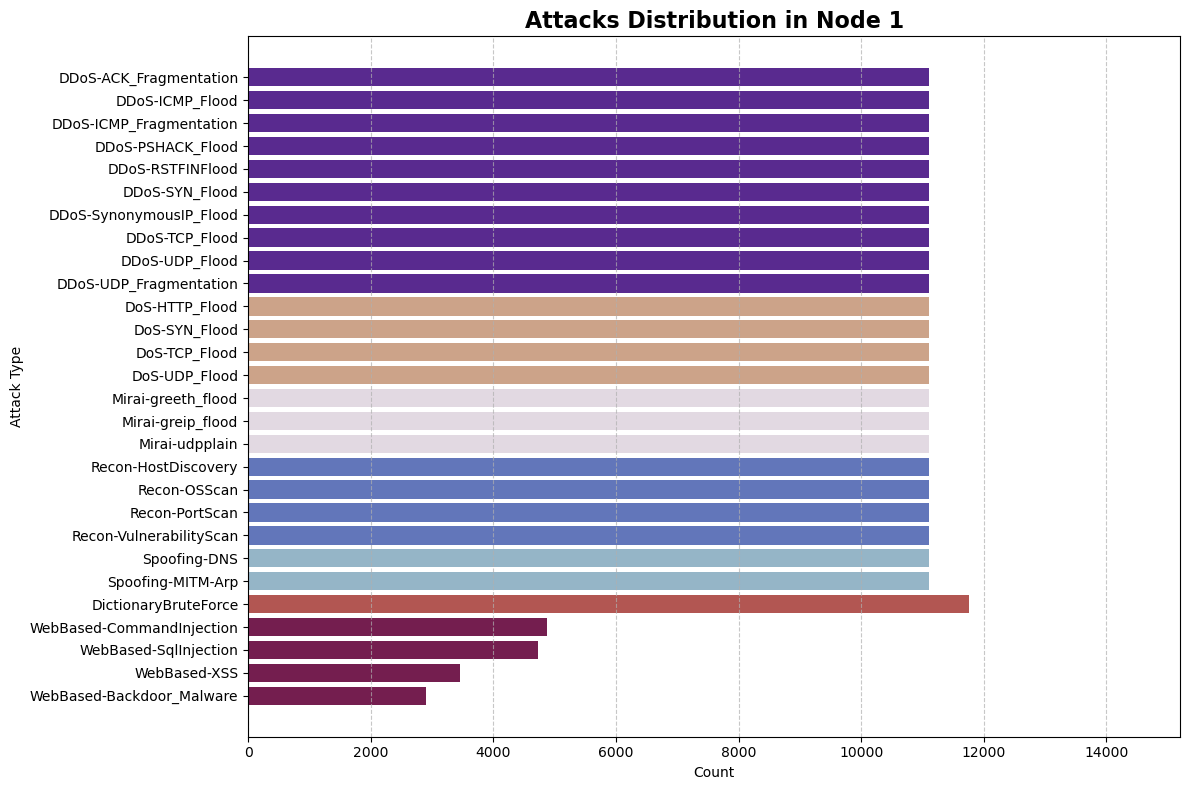

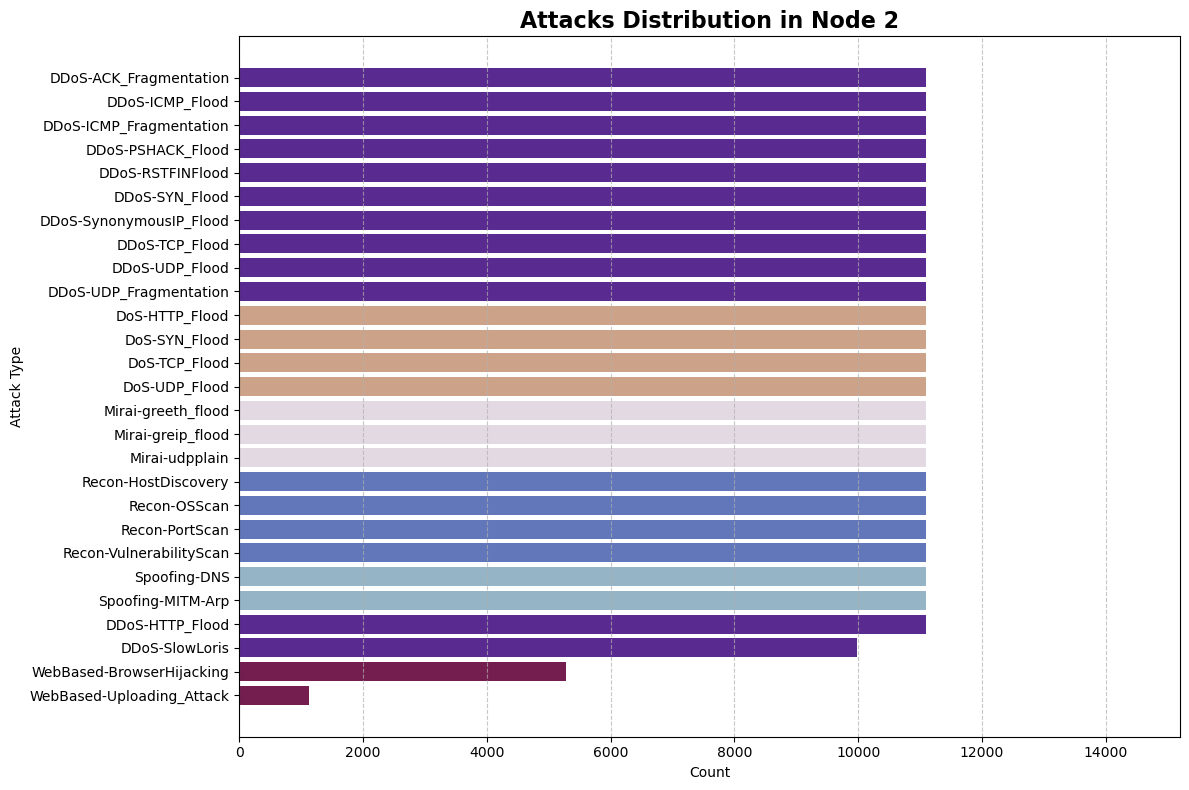

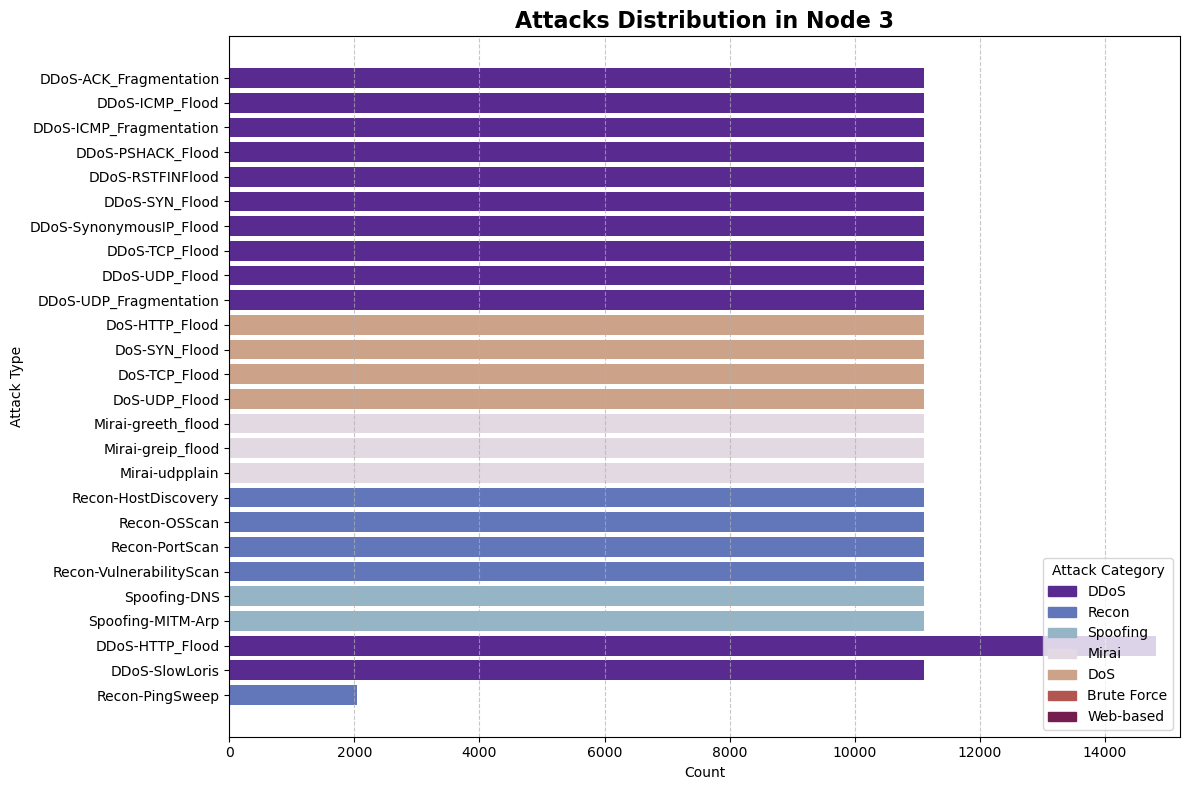

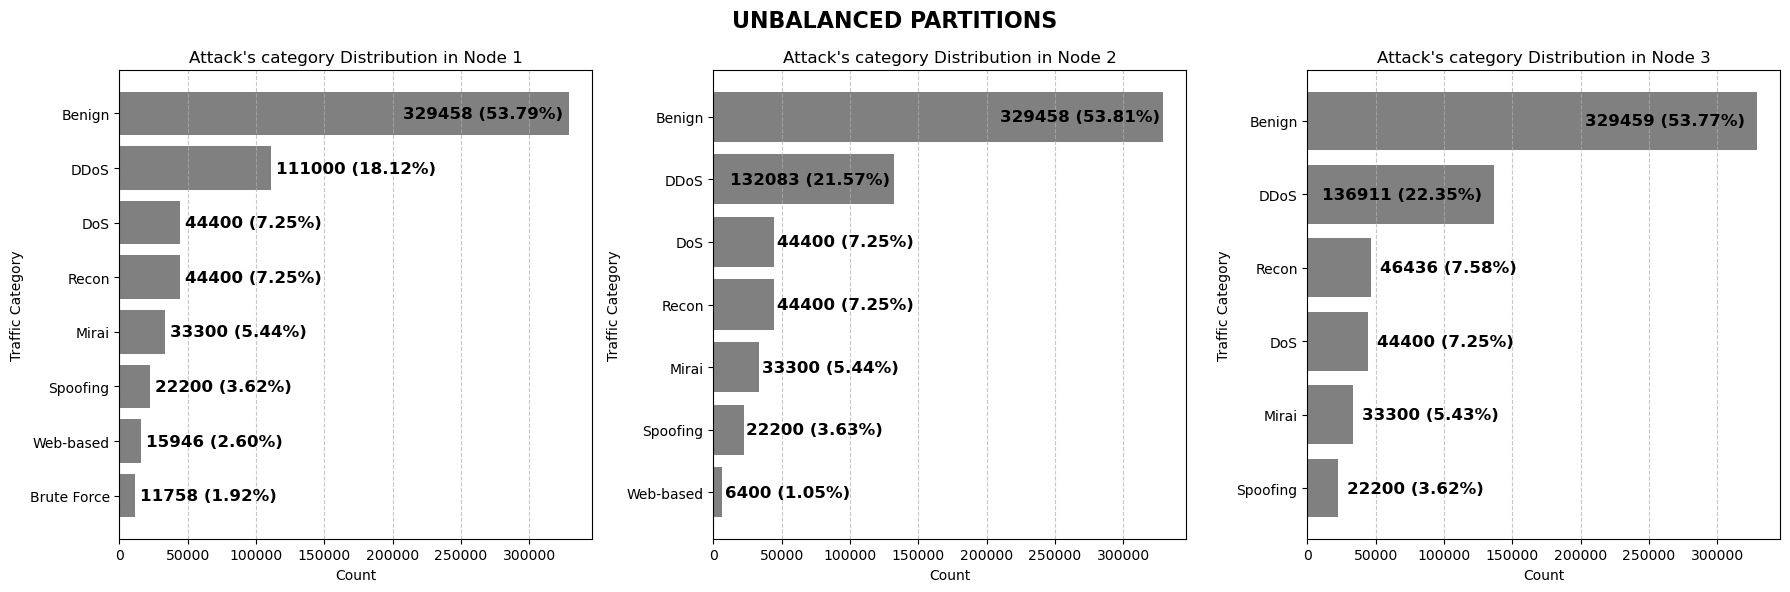

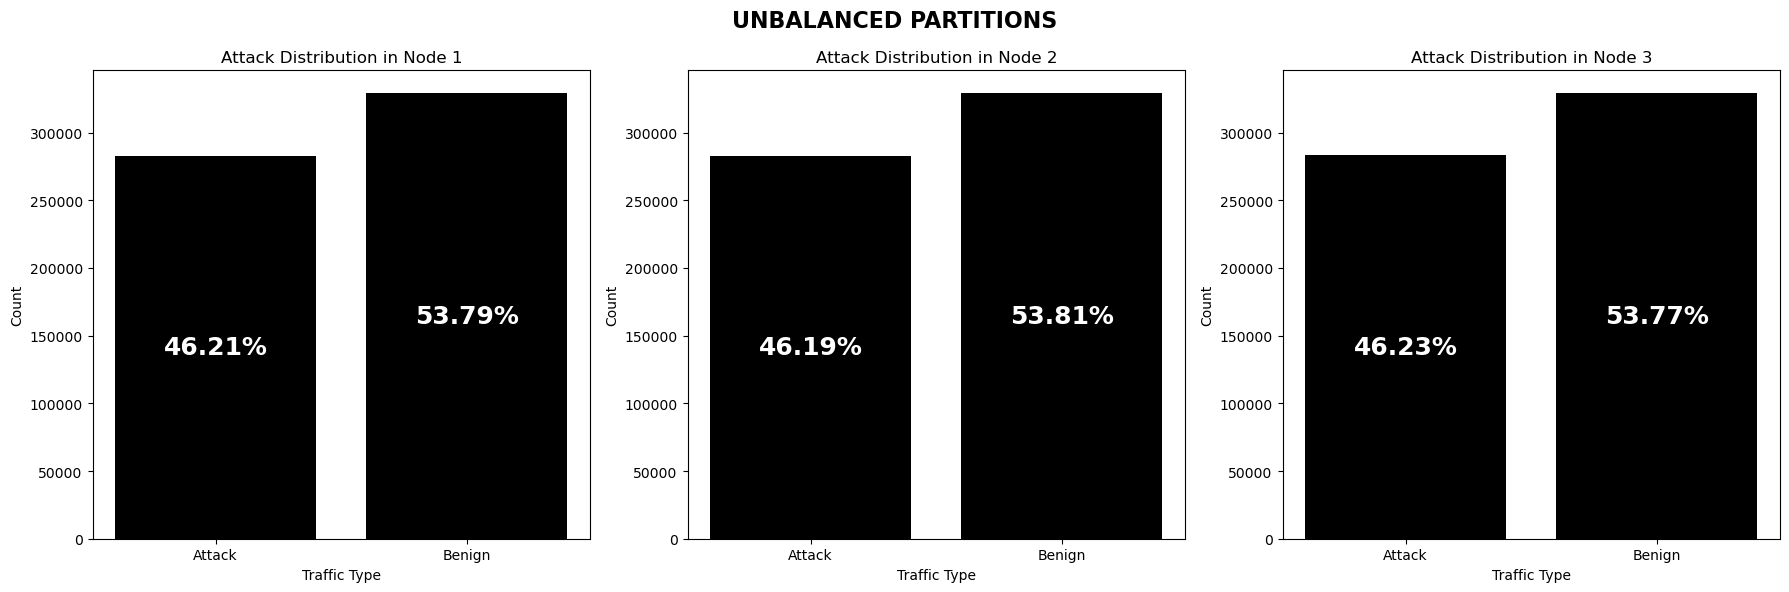

In [34]:
AttackTypeDistribution(partitions_ub3, nodes, df_labels, "unbalanced")
AttackCategoryDistribution(partitions_ub3, nodes, df_labels, part="UNBALANCED PARTITIONS")
TrafficDistribution(partitions_ub3, nodes, "UNBALANCED PARTITIONS")

Save the partitions:

In [ ]:
os.makedirs("..\\datasets\\UNBALANCED", exist_ok=True)
for i in range(nodes):
    reverse_preprocessing(partitions_ub3[f"part_{i}"]).to_csv(f"..\\datasets\\UNBALANCED\\unbalanced_part{i}.csv",index=False)
    reverse_preprocessing(partitions_ub3[f"part_{i}"]).to_csv(f"..\\datasets\\UNBALANCED\\unbalanced_part{i}.zip",index=False, compression={'method': 'zip', 'archive_name': f'unbalanced_part{i}.csv'})